# MONODEPTH on OpenVINO IR Model

This notebook demonstrates Monocular Depth Estimation with MidasNet in OpenVINO. Model information: https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/midasnet/midasnet.md

THIS IS A WORK IN PROGRESS NOTEBOOK. IT IS NOT FOR PUBLIC RELEASE. See the [README](README.md) for instructions on how to run this notebook on your own computer.

<img src="monodepth.gif">

### What is Monodepth?
Monocular Depth Estimation is the task of estimating scene depth using a single image. It has many potential applications in robotics, 3D reconstruction, medical imaging and autonomous systems. For this demo, we use a neural network model called [MiDaS](https://github.com/intel-isl/MiDaS) which was developed by the Intelligent Systems Lab at Intel. Check out their research paper to learn more. 

R. Ranftl, K. Lasinger, D. Hafner, K. Schindler and V. Koltun, ["Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer,"](https://ieeexplore.ieee.org/document/9178977) in IEEE Transactions on Pattern Analysis and Machine Intelligence, doi: 10.1109/TPAMI.2020.3019967.

## Preparation 

### Install required Python\* packages

Install the required Python\* packages by executing `pip install -r requirements.txt` in a terminal, in the directory that contains this notebook. See the [README](https://github.com/helena-intel/openvino-notebooks/blob/develop/README.md) for more details and instructions for how to set up a virtual environment. 

You can also uncomment and run the cell below to install these requirements. Note that installation may take a while. There is no progress indicator.

In [1]:
# !pip install openvino-dev matplotlib pytube Pillow

### Imports

In [2]:
import os
import time
import urllib
from pathlib import Path

import cv2
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
from openvino.inference_engine import IECore

from pytube import YouTube
from IPython.display import HTML, Pretty, ProgressBar, clear_output

### Settings

In [3]:
DEVICE = "CPU"
MODEL_DIR = "models"
MODEL_URL = "https://officemacros.nl/midasnet.xml"  # DEBUG: this should be moved to an official download link

model_name = os.path.basename(MODEL_URL)
model_xml_path = Path(MODEL_DIR) / model_name

/Users/rlo/Documents/openvino_dev/raymondlo84/openvino_env/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Functions

In [4]:
def normalize_minmax(data):
    """Normalizes the values in `data` between 0 and 1"""
    return (data - data.min()) / (data.max() - data.min())

In [5]:
def download_ir_model(model_xml_url, directory):
    """
    Downloads IR model from `model_xml_url` and save it to `directory` with the same filename. The directory will be
    created if it does not exist.
    """
    os.makedirs(directory, exist_ok=True)
    model_name = os.path.basename(model_xml_url)
    model_xml_path = f"{directory}/{model_name}"
    if not os.path.exists(model_xml_path):
        urllib.request.urlretrieve(model_xml_url, model_xml_path)
        urllib.request.urlretrieve(model_xml_url[:-4] + ".bin", f"{model_xml_path[:-4]}.bin")
        print(f"Model {model_name} downloaded to {directory}")
    else:
        print(f"Model {model_name} already exists in {directory}")

In [6]:
def load_image(path: str):
    """
    Loads an image from `path` and returns it as BGR numpy array. `path` should point to an image file,
    either a local filename or an url.
    """
    if path.startswith("http"):
        # Set User-Agent to Mozilla because some websites block requests with User-Agent Python
        request = urllib.request.Request(path, headers={"User-Agent": "Mozilla/5.0"})
        response = urllib.request.urlopen(request)
        array = np.asarray(bytearray(response.read()), dtype="uint8")
        image = cv2.imdecode(array, -1)  # Loads the image as BGR
    else:
        image = cv2.imread(path)
    return image

In [7]:
def convert_result_to_image(result, colormap="viridis"):
    """
    Convert network result of floating point numbers to an RGB image with integer values from 0-255
    by applying a colormap.

    `result` is expected to be a single network result in 1,H,W shape
    `colormap` is a matplotlib colormap. See https://matplotlib.org/stable/tutorials/colors/colormaps.html
    """
    cmap = matplotlib.cm.get_cmap(colormap)
    result = result.squeeze(0)
    result = normalize_minmax(result)
    result = cmap(result)[:, :, :3] * 255
    result = result.astype(np.uint8)
    return result

## Load model and get model information

Load the model in Inference Engine with `ie.read_network` and load it to the specified device with `ie.load_network`

In [8]:
print("Download Model... Please wait...")
download_ir_model(MODEL_URL, MODEL_DIR)

Model midasnet.xml downloaded to models


In [9]:
ie = IECore()
net = ie.read_network(str(model_xml_path), str(model_xml_path.with_suffix(".bin")))
exec_net = ie.load_network(network=net, device_name=DEVICE)

input_key = list(exec_net.input_info)[0]
output_key = list(exec_net.outputs.keys())[0]

network_input_shape = exec_net.input_info[input_key].tensor_desc.dims
network_image_height, network_image_width = network_input_shape[2:]

## Monodepth on Image

### Load, resize and reshape input image

The input image is read with OpenCV, resized to network input size, and reshaped to (N,C,H,W) (H=height, W=width, C=number of channels, N=number of images). 

In [10]:
# Download and load an image
# Image source (CC license): https://storage.googleapis.com/openimages/web/visualizer/index.html?set=train&type=segmentation&r=false&c=%2Fm%2F02rgn06&id=470c2f96cb938855
IMAGE_URL = r"https://officemacros.nl/image.jpg"  # TODO: move to storage.openvinotoolkit.org

image = load_image(IMAGE_URL)
resized_image = cv2.resize(image, (network_image_height, network_image_width))  # resize to input shape for network
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)  # reshape image to network input shape NCHW

### Do inference on image

Do the inference, convert the result to an image, and resize it to the original image shape

In [11]:
result = exec_net.infer(inputs={input_key: input_image})[output_key]
# convert network result of disparity map to an image that shows distance as colors
result_image = convert_result_to_image(result)
# resize back to original image shape. cv2.resize expects shape in (width, height), [::-1] reverses the (height, width) shape to match this.
result_image = cv2.resize(result_image, image.shape[:2][::-1])

### Display monodepth image

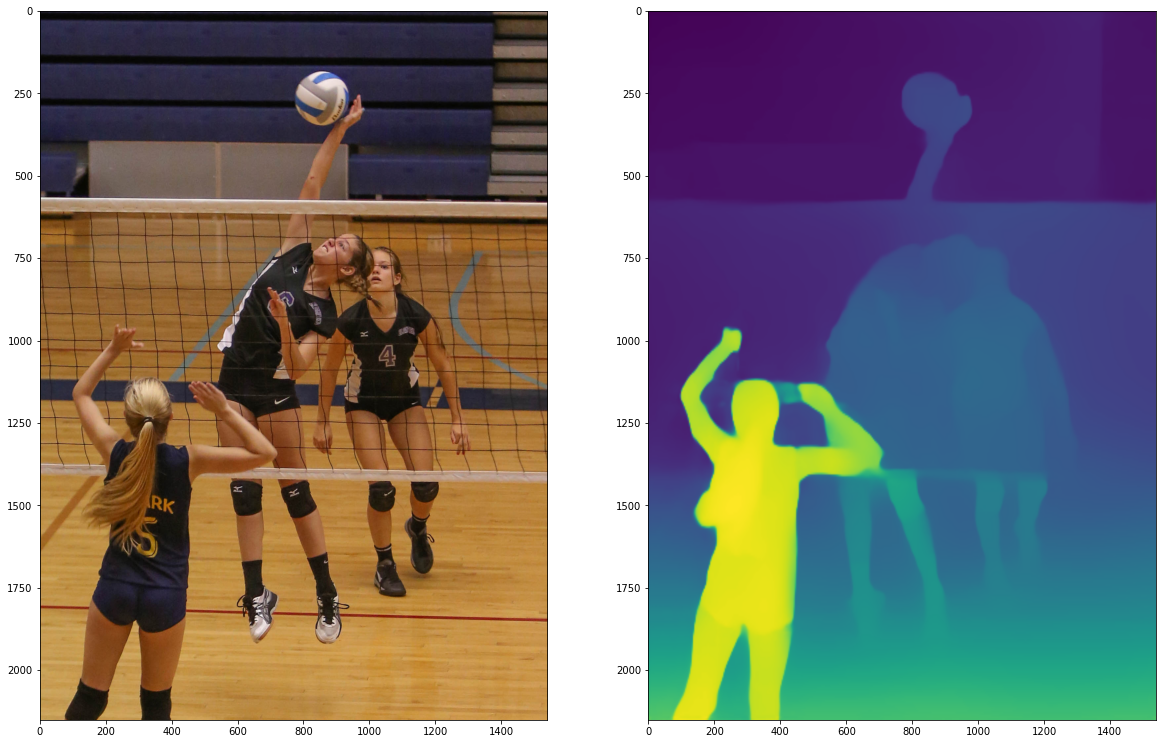

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 15))
ax[0].imshow(image[:, :, (2, 1, 0)])  # (2,1,0) converts the image from BGR to RGB
ax[1].imshow(result_image);

## Monodepth on Video

Uses pytube for quickly downloading a video from Youtube.

By default, only the first 100 frames are processed, in order to quickly check that everything works. Change NUM_FRAMES in the cell below to modify this. Set NUM_FRAMES to 0 to process the whole video.

### Download and load video

In [13]:
NUM_FRAMES = 100  # Number of video frames to process. Set to 0 to process all frames.
VIDEO_URL = "https://youtu.be/nAcKK6mb_vk"  # Drone
VIDEO_URL = "https://www.youtube.com/watch?v=HL0-0KFQi50"  # Coco Walking in Berkeley
VIDEO_DIR = "videos"

# Use PyTube to download a video to VIDEO_DIR
yt = YouTube(VIDEO_URL)
# Use `yt.streams` to see all available streams. See the PyTube documentation https://python-pytube.readthedocs.io/en/latest/api.html for advanced filtering options
stream = yt.streams.filter(resolution="360p").first()

stream.download(VIDEO_DIR)
print(f"Video {stream.default_filename} download to {VIDEO_DIR}")

# Create Path objects for the input video and the resulting video
video_path = Path(VIDEO_DIR) / stream.default_filename
result_video_path = video_path.with_name(f"{video_path.stem}_monodepth.mkv")

Video Coco Walking in Berkeley.mp4 download to videos


In [14]:
cap = cv2.VideoCapture(str(video_path))
_, image = cap.read()
FPS = cap.get(cv2.CAP_PROP_FPS)
FRAME_HEIGHT, FRAME_WIDTH = image.shape[:2]
FOURCC = cv2.VideoWriter_fourcc(*"THEO")

cap.release()
print(f"The input video has a frame width of {FRAME_WIDTH}, frame height of {FRAME_HEIGHT} and runs at {FPS} fps")

The input video has a frame width of 640, frame height of 360 and runs at 30.0 fps


### Do Inference on video and create monodepth video

In [15]:
frame_nr = 1
start_time = time.perf_counter()
total_inference_duration = 0

cap = cv2.VideoCapture(str(video_path))
out_video = cv2.VideoWriter(
    str(result_video_path),
    FOURCC,
    FPS,
    (FRAME_WIDTH * 2, FRAME_HEIGHT),
)

total_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) if NUM_FRAMES == 0 else NUM_FRAMES
progress_bar = ProgressBar(total=total_frames)
progress_bar.display()

try:
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            cap.release()
            break

        if frame_nr == total_frames:
            break

        # Prepare frame for inference
        resized_image = cv2.resize(image, (network_image_height, network_image_width))  # resize to input shape for network
        input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)  # reshape image to network input shape NCHW

        # Do inference
        inference_start_time = time.perf_counter()
        result = exec_net.infer(inputs={input_key: input_image})[output_key]
        inference_stop_time = time.perf_counter()
        inference_duration = inference_stop_time - inference_start_time
        total_inference_duration += inference_duration

        if frame_nr % 10 == 0:
            clear_output(wait=True)
            progress_bar.display()
            display(
                Pretty(f"Processed frame {frame_nr}. Inference time: {inference_duration:.2f} seconds ({1/inference_duration:.2f} FPS)")
            )

        # Transform network result to image
        result_frame = convert_result_to_image(result)[:, :, (2, 1, 0)]  # Convert result from RGB to BGR
        # Resize to original image shape
        result_frame = cv2.resize(result_frame, (FRAME_WIDTH, FRAME_HEIGHT))
        # Put image and result side by side
        stacked_frame = np.hstack((image, result_frame))
        # Save frame to video
        out_video.write(stacked_frame)

        frame_nr = frame_nr + 1
        progress_bar.progress = frame_nr
        progress_bar.update()

except KeyboardInterrupt:
    print("Processing interrupted.")
finally:
    out_video.release()
    cap.release()
    end_time = time.perf_counter()
    duration = end_time - start_time
    clear_output()
    print(f"Monodepth Video saved to '{str(result_video_path)}'.")
    print(
        f"Processed {frame_nr} frames in {duration:.2f} seconds. Total FPS (including video processing): {frame_nr/duration:.2f}. Inference FPS: {frame_nr/total_inference_duration:.2f} "
    )

Monodepth Video saved to 'videos/Coco Walking in Berkeley_monodepth.mkv'.
Processed 100 frames in 43.01 seconds. Total FPS (including video processing): 2.33. Inference FPS: 2.57 


### Display monodepth video

If the video is not displayed correctly, you can also play it locally. 

In [16]:
from IPython.display import Video

print(f"Showing monodepth video {result_video_path.resolve()}")
Video(result_video_path, width=800)

Showing monodepth video /Users/rlo/Documents/openvino_dev/raymondlo84/openvino-notebooks/201-vision-monocular-depth-estimation/videos/Coco Walking in Berkeley_monodepth.mkv
